# 分区统计

In [1]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import matplotlib.colors
import sys
sys.path.append("..")
%matplotlib inline

period_colors = ['#0889A6', '#F1801F', '#006C43']
region_colors = ["#0077b6", "#e07a5f", "#f2cc8f","#81b29a"]
index_colors = ['#CFA7D1', '#79D6F0', '#E25A53']
index_colormap = matplotlib.colors.ListedColormap(index_colors, 'indexed')
total_water_use_color = '#D1495B'

## 加载数据

In [2]:
# 加载阈值为 0.05的数据，即与黄河流域相交面积大于全市总面积 5% 的所有市
city_yr = pd.read_csv(
    '../data/perfectures/yr/perfectures_in_YR_with_threshold_0.05.csv',
    index_col=0)

regions = city_yr['Region'].unique()
city_yr.shape
city_yr.head()

,Year,IRR,Irrigated area: Total,Irrigated area: Rice,Irrigated area: Wheat,Irrigated area: Maize,Irrigated area: Vegetables and fruits,Irrigated area: Others,Irrigation water-use intensity (WUI): Total,Irrigation water-use intensity (WUI): Rice,...,Rural domestic WUI,Rural livestock WU,Livestock population,Livestock WUI,Total water use,Province_n,Area_calcu,Region,Intersect_area,Ratio
City_ID,,,,,,,,,,,,,,,,,,,,,
C27,1965,0.300518,46.631997,0.391448,16.089679,1.152312,0.571298,28.427261,644.445209,965.436106,...,31.895556,0.003203,141.750766,0.022595,0.328586,Gansu,20091.467281,UR,19188.439369,0.955054
C27,1966,0.323595,49.468303,0.383836,16.485679,1.434736,0.636613,30.527440,654.146772,979.121070,...,28.371723,0.003336,147.646616,0.022592,0.351996,Gansu,20091.467281,UR,19188.439369,0.955054
C27,1967,0.340063,52.309331,0.416675,17.803304,1.442818,0.697033,31.949501,650.100439,973.012862,...,21.033715,0.003413,151.033245,0.022600,0.372432,Gansu,20091.467281,UR,19188.439369,0.955054
C27,1968,0.352690,53.870788,0.437429,18.863369,1.514685,0.770592,32.284713,654.695280,979.011409,...,22.233352,0.003487,154.266500,0.022604,0.391458,Gansu,20091.467281,UR,19188.439369,0.955054
C27,1969,0.365740,55.120730,0.447621,19.700679,1.549920,0.752680,32.669830,663.524461,992.248499,...,32.825618,0.003575,158.251492,0.022594,0.406136,Gansu,20091.467281,UR,19188.439369,0.955054


## 数据所有列名

In [3]:
for col in city_yr.columns:
    print(col)

Year
IRR
Irrigated area: Total
Irrigated area: Rice
Irrigated area: Wheat
Irrigated area: Maize
Irrigated area: Vegetables and fruits
Irrigated area: Others
Irrigation water-use intensity (WUI): Total
Irrigation water-use intensity (WUI): Rice
Irrigation water-use intensity (WUI): Wheat
Irrigation water-use intensity (WUI): Maize
Irrigation water-use intensity (WUI): Vegetables and fruits
Irrigation water-use intensity (WUI): Others
IND
Industrial gross value added (GVA): Total
Industrial gross value added (GVA): Textile
Industrial gross value added (GVA): Papermaking
Industrial gross value added (GVA): Petrochemicals
Industrial gross value added (GVA): Metallurgy
Industrial gross value added (GVA): Mining
Industrial gross value added (GVA): Food
Industrial gross value added (GVA): Cements
Industrial gross value added (GVA): Machinery
Industrial gross value added (GVA): Electronics
Industrial gross value added (GVA): Thermal electrivity
Industrial gross value added (GVA): Others
Indust

In [4]:
# 所有农业、工业wui的列
wui_cols = []
for col in city_yr:
    if "WUI" in col:
        if "Irrigat" in col or "Industrial" in col:
            wui_cols.append(col)

# 将所有WUI的列与相应的
import re
pattern = re.compile(r"\W*WUI\W*")
match_results = {}
for wui_col_name in wui_cols:
    wui = wui_col_name.replace("Irrigation water-use intensity", "Irrigate")
    splited_list = re.split(pattern, wui)
    for col in city_yr.drop(wui_cols, axis=1):
        bool_list = [_.strip() in col for _ in splited_list]
        if all(bool_list):
            match_results[wui_col_name] = col
            break

match_results

{'Irrigation water-use intensity (WUI): Total': 'Irrigated area: Total',
 'Irrigation water-use intensity (WUI): Rice': 'Irrigated area: Rice',
 'Irrigation water-use intensity (WUI): Wheat': 'Irrigated area: Wheat',
 'Irrigation water-use intensity (WUI): Maize': 'Irrigated area: Maize',
 'Irrigation water-use intensity (WUI): Vegetables and fruits': 'Irrigated area: Vegetables and fruits',
 'Irrigation water-use intensity (WUI): Others': 'Irrigated area: Others',
 'Industrial WUI: Total': 'Industrial gross value added (GVA): Total',
 'Industrial WUI: Textile': 'Industrial gross value added (GVA): Textile',
 'Industrial WUI: Papermaking': 'Industrial gross value added (GVA): Papermaking',
 'Industrial WUI: Petrochemicals': 'Industrial gross value added (GVA): Petrochemicals',
 'Industrial WUI: Metallurgy': 'Industrial gross value added (GVA): Metallurgy',
 'Industrial WUI: Mining': 'Industrial gross value added (GVA): Mining',
 'Industrial WUI: Food': 'Industrial gross value added (GV

In [5]:
for col in city_yr:
    if re.findall(re.compile(r"\bWU\b"), col):
        col

In [6]:
# 新建一个表，装所有利用 WUI 和存量 相乘得到的 WU
multipled_wu = pd.DataFrame(index=city_yr.index)

# 把所有农业工业有关的 WU 列存入
for wui, stock in match_results.items():
    if "Total" in wui:
        continue
    if "Industrial" in wui:
        wu = city_yr[wui] * city_yr[stock]
    if "Irrigat" in wui:
        wu = city_yr[wui] / 1000 / 1000 * city_yr[stock] * 10
    multipled_wu[wui.replace("WUI", "WU")] = wu
    
# 把所有人居牲畜服务业有关的 WU 列存入
other_wu_cols = [] 
for col in city_yr:
    if re.findall(re.compile(r"\bWU\b"), col):
        other_wu_cols.append(col)
        
for col in other_wu_cols:
    multipled_wu[col] = city_yr[col]
for col in ['Year', 'Region']:
    multipled_wu[col] = city_yr[col]
    
multipled_wu.head()

,Irrigation water-use intensity (WU): Rice,Irrigation water-use intensity (WU): Wheat,Irrigation water-use intensity (WU): Maize,Irrigation water-use intensity (WU): Vegetables and fruits,Irrigation water-use intensity (WU): Others,Industrial WU: Textile,Industrial WU: Papermaking,Industrial WU: Petrochemicals,Industrial WU: Metallurgy,Industrial WU: Mining,...,Industrial WU: Machinery,Industrial WU: Electronics,Industrial WU: Thermal electrivity,Industrial WU: Others,Urban domestic WU,Urban service WU,Rural domestic WU,Rural livestock WU,Year,Region
City_ID,,,,,,,,,,,,,,,,,,,,,
C27,0.003779,0.103939,0.009491,0.004976,0.178333,0.004398,0.001173,0.000685,0.000541,0.000196,...,0.000082,0.000358,0.000436,0.003066,0.005398,0.001883,0.005818,0.003203,1965,UR
C27,0.003758,0.108007,0.011985,0.005623,0.194222,0.003127,0.000893,0.000540,0.000438,0.000161,...,0.000067,0.000272,0.000364,0.005473,0.005488,0.001848,0.005733,0.003336,1966,UR
C27,0.004054,0.115911,0.011977,0.006118,0.202002,0.007806,0.002387,0.001494,0.001247,0.000462,...,0.000191,0.000726,0.001064,0.000000,0.005393,0.001687,0.004650,0.003413,1967,UR
C27,0.004282,0.123570,0.012652,0.006806,0.205379,0.009600,0.003142,0.002039,0.001751,0.000655,...,0.000268,0.000956,0.001533,0.000000,0.005647,0.001818,0.005322,0.003487,1968,UR
C27,0.004442,0.130800,0.013121,0.006737,0.210639,0.004490,0.001573,0.001059,0.000935,0.000353,...,0.000143,0.000478,0.000840,0.008542,0.006340,0.002293,0.008437,0.003575,1969,UR


## 数据字典:

title | unit | describe
-- | -- | --
Total water use (WU) |	km3 yr-1 	| The sum of IRR, IND, URB, and RUR
Irrigation WU (IRR)|	km3 yr-1|	Annual quantity of water withdrawn for irrigation including the losses during conveyance and field application, but it does not include water for pasture or aquaculture
Irrigated area	| thousand ha	| Area equipped for irrigation by crop
Irrigation water-use intensity (WUI)|	mm	|The water used per unit of irrigated area by crop
Industrial WU (IND)	|km3 yr-1|	Annual quantity of water withdrawn for industrial purposes, including self-supplied industries and the industries that are connected to the public supply network
Industrial gross value added (GVA)|	Billion Yuan|	Industrial GVA by industries
Industrial WUI	|m3 Yuan-1	|WU per unit of GVA for all industries
Urban WU (URB)	|km3 yr-1|	The sum of water withdrawn for direct uses by urban residents and service activities
Urban domestic WU	|km3 yr-1	|Annual quantity of water withdrawn by the public supply network for the direct uses by urban residents
Urban population	|million Capita	|The number of urban residents, including urban residents registered with urban residential permit (‘hukou’) and rural residents who migrate to urban regions no matter what they get urban hukou or not
Urban domestic WUI	|Liter capita-1 day-1|	Urban domestic WU per capita of urban population
Urban service WU	|km3 yr-1|	Annual quantity of water withdrawn by the public supply network for the direct uses by service activities
Service GVA	|billion Yuan|	GVA of service activities
Service WUI 	|m3 Yuan-1|	WU per unit of GVA of service activities
Rural WU (RUR)	|km3 yr-1|	Annual quantity of water withdrawn by the public supply network for the direct uses by rural residents and livestock
Rural domestic WU	|km3 yr-1|	Annual quantity of water withdrawn by the public supply network for the direct uses by rural residents
Rural population	|million Capita|	Population living in rural regions
Rural domestic WUI	|Liter capita-1 day-1|	Rural domestic WU per capita of rural population
Rural livestock WU	|km3 yr-1|	Annual quantity of water withdrawn by the public supply network for livestock drinking and cleaning
Livestock population	|billion KJ	|Livestock commodity calories summed from 7 types of animal 
Livestock WUI	|Liter KJ-1|	WU per unit of livestock commodity calories

## 总用水量趋势

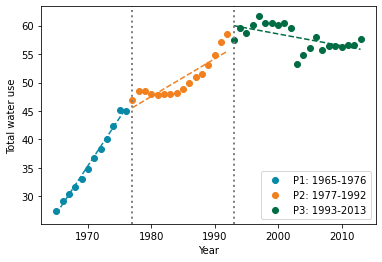

In [7]:
from tools.statistic import plot_pittitt_change_points
twu = city_yr.groupby("Year")['Total water use'].sum()
twu_slopes = plot_pittitt_change_points(twu, change_points=[1977, 1993], colors=period_colors)
plt.xlabel("Year")
plt.ylabel("Total water use")

# plt.savefig("../figures/sup/total_water_use.jpg", dpi=300)
plt.show();

## 各区域总用水量

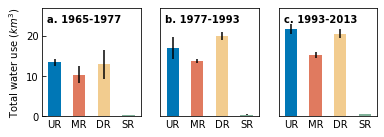

In [8]:
twu_regions = city_yr.groupby(["Region", "Year"])['Total water use'].sum()
twu_regions = pd.DataFrame({r: twu_regions.loc[r] for r in regions})

fig, axs = plt.subplots(1, 3, figsize=(6, 2))
endpoints = [1977, 1993, 2013]
markers = ["a.", "b.", "c."]
startpoint = twu_regions.index.min()
for i, endpoint in enumerate(endpoints):
    ax = axs[i]
    use_data = twu_regions.loc[startpoint: endpoint, :]
    use_data.mean().plot.bar(yerr=use_data.std(), ax=ax, color=region_colors)
    ax.set_ylim(0, 27)
    ax.text(1.2, 24, "{} {}-{}".format(markers[i], startpoint, endpoint), ha='center', va='center', weight='bold')
    startpoint = endpoint
    ax.axes.get_yaxis().set_visible(False)
    ax.tick_params(axis='x', tickdir='in', bottom=False, labelrotation=0)
    ax.tick_params(axis='y', tickdir='in', bottom=False, labelrotation=0)
    
axs[0].set_ylabel("Total water use ($km^3$)")
axs[0].axes.get_yaxis().set_visible(True)
# plt.savefig("../figures/sup/sf_total_water_use_regions.jpg", dpi=300)
plt.show();

## 分部门用水量

In [9]:
def plot_percentages(data, years=[1965, 1977, 1993, 2013], ax=None, colors=None):
    percentage = data.apply(lambda row: row/row.sum(), axis=1).loc[years]
    if ax is None:
        fig, ax = plt.subplots()
    bottom = np.zeros(data.shape[1])
    for i, col in enumerate(percentage):
        y = percentage[col]
        if colors is None:
            ax.bar(x=np.arange(data.shape[1]), height=y, bottom=bottom)
        else:
            ax.bar(x=np.arange(data.shape[1]), height=y, bottom=bottom, color=colors[i])
        bottom += y
    ax.set_ylim(0, 1)
    ax.set_ylabel("Proportion")
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(years)
    return percentage

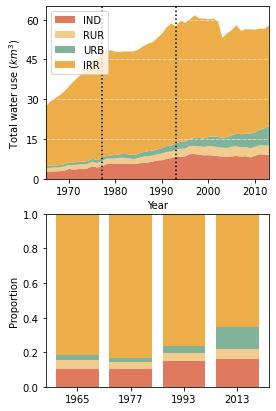

In [10]:
wu_cols = ['IND', 'RUR', 'URB', 'IRR']
wu_sections = city_yr.groupby(["Year"])[wu_cols].sum()

# 绘图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 7))
ax1.stackplot(wu_sections.index, wu_sections.T, labels=wu_cols, colors=["#e07a5f", "#f2cc8f","#81b29a", "#EDAE49"])
ax1.set_xlabel("Year")
ax1.set_ylabel("Total water use ($km^3$)")
ax1.set_xlim(wu_sections.index.min(), wu_sections.index.max())
ax1.set_yticks(np.arange(0, 61, 15))
ax1.set_ylim(0, 65)
ax1.yaxis.grid(color='white', linestyle='-.', linewidth=0.5)
ax1.axvline(x=1977, ls=":", lw=1.5, c='black')
ax1.axvline(x=1993, ls=":", lw=1.5, c='black')
ax1.legend(loc=2)
    
percentages = plot_percentages(wu_sections, colors=["#e07a5f", "#f2cc8f","#81b29a", "#EDAE49"], ax=ax2)
plt.savefig("../figures/sup/sf_wu_sections_stackplot.jpg", dpi=300)
plt.show();

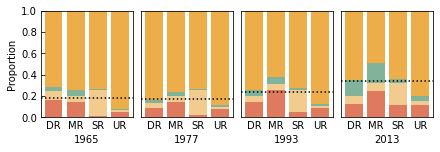

In [11]:
wu_sections = city_yr.groupby(["Year", "Region"])[wu_cols].sum()
check_years = [1965, 1977, 1993, 2013]

fig, axs = plt.subplots(1, 4, figsize=(6, 2), constrained_layout=True)
for i, yr in enumerate(check_years):
    use_data = wu_sections.loc[yr, wu_cols]
    benchmark = use_data.sum() / use_data.sum().sum()
    plot_percentages(use_data, years=use_data.index.tolist(), ax=axs[i], colors=["#e07a5f", "#f2cc8f","#81b29a", "#EDAE49"])
    axs[i].axes.get_yaxis().set_visible(False)
    axs[i].tick_params(axis='x', tickdir='in', bottom=False, labelrotation=0)
    axs[i].tick_params(axis='y', tickdir='in', bottom=False, labelrotation=0)
    axs[i].set_xlabel(yr)
    axs[i].axhline(1-benchmark.max(), ls=":", c="black")
        
axs[0].axes.get_yaxis().set_visible(True)
# plt.savefig("../figures/sup/sf_proportion_regions.jpg", dpi=300)
plt.show();

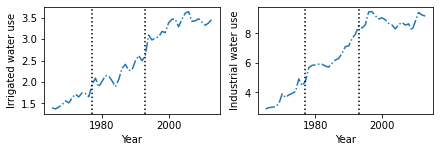

In [12]:
# 整个流域的农业、工业用水
gva_sum = city_yr.groupby(['Year']).sum()[['RUR', 'IND']]
fig, axs = plt.subplots(1, 2, figsize=(6, 2), constrained_layout=True)

for i, ax in enumerate(axs):
    ax.plot(gva_sum.iloc[:, i], "-.")
    ax.set_xlabel("Year")
    ax.axvline(x=1977, ls=":", lw=1.5, c='black')
    ax.axvline(x=1993, ls=":", lw=1.5, c='black')
    
axs[0].set_ylabel("Irrigated water use")
axs[1].set_ylabel("Industrial water use")
# plt.savefig("../figures/sup/rur_and_ind_YRB.jpg", dpi=300)
plt.show();

# 用水密度

## 自动作折线图比较函数

In [13]:
# 一共将黄河流域分为“源区 Source Region”，“上游 Upper Region”，“中游 Middle Region”，“下游 Down Region”四个区
# 每个区都有近60年的数据，所以先考虑采用折线图进行绘图比较趋势

regions = ['SR', 'UR', 'MR', 'DR']
# colors = ['']  # 将来可以设置自定义四个区域的颜色

def compare_regions_lineplot(data, col=None, ax=None):
    # data 应该是根据 ['Region', 'Year'] 进行groupby之后的数据
    # col是需要对比的变量
    """自动生成对比四个区域某变量变化的折线图"""
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(regions)):
        region = regions[i]
        if col is None: data[region].plot(ax=ax, label=region)
        else: data[col][region].plot(ax=ax, label=region)
    ax.set_ylabel(col)

## 提取 “WUI” 有关的列

In [14]:
# 提取所有包含“用水密度”的列名
water_use_density = []
for col in city_yr.columns:
    if 'WUI' in col:
        water_use_density.append(col)
        
print("包含“用水密度”的列：")
water_use_density

包含“用水密度”的列：


['Irrigation water-use intensity (WUI): Total',
 'Irrigation water-use intensity (WUI): Rice',
 'Irrigation water-use intensity (WUI): Wheat',
 'Irrigation water-use intensity (WUI): Maize',
 'Irrigation water-use intensity (WUI): Vegetables and fruits',
 'Irrigation water-use intensity (WUI): Others',
 'Industrial WUI: Total',
 'Industrial WUI: Textile',
 'Industrial WUI: Papermaking',
 'Industrial WUI: Petrochemicals',
 'Industrial WUI: Metallurgy',
 'Industrial WUI: Mining',
 'Industrial WUI: Food',
 'Industrial WUI: Cements',
 'Industrial WUI: Machinery',
 'Industrial WUI: Electronics',
 'Industrial WUI: Thermal electrivity',
 'Industrial WUI: Others',
 'Urban domestic WUI',
 'Service WUI',
 'Rural domestic WUI',
 'Livestock WUI']

- 灌溉有关的用水密度：总农业用水密度（单位有效灌溉面积的耗水量），以及水稻、小麦、玉米、蔬菜水果、其它，这五类各自的单位有效灌溉面积耗水量。
- 工业有关的用水密度：总工业用水密度，（每元产出耗水），以及分行业，纺织、造纸、化工、冶金、采矿、粮食、水泥、机械、电子、发电、其它
- 城市居民用水密度：平均每人每天的用水量
- 服务业用水密度：每元产出耗水
- 农村居民
- 牲畜

## 各行业WUI比较

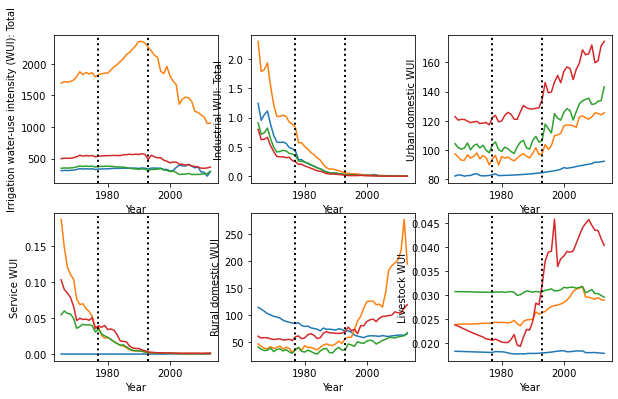

In [15]:
# 各个区域的不同类别 WUI 的平均值比较
WUI_mean = city_yr.groupby(['Region', 'Year']).mean()[water_use_density]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 6))
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

# 对比各行业总列，先不细分到二级
wui_cols = [
    'Irrigation water-use intensity (WUI): Total', 'Industrial WUI: Total',
    'Urban domestic WUI', 'Service WUI', 'Rural domestic WUI', 'Livestock WUI'
]

# 绘图
for i in range(6):
    ax, wui_col = axs[i], wui_cols[i]
    compare_regions_lineplot(WUI_mean, wui_col, ax)

    # 增加辅助线
    ax.axvline(x=1977, ls=":", c='black', lw=2, label='Breakpoint_1: 1978')
    ax.axvline(x=1993, ls=":", c='black', lw=2, label='Breakpoint_2: 1993')

plt.show();

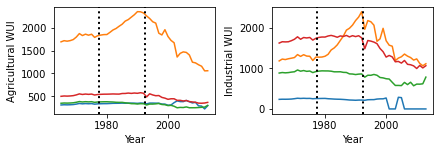

In [16]:
# 对比农业和工业WUI
WUI_mean = city_yr.groupby(['Region', 'Year']).mean()[water_use_density[:2]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2), constrained_layout=True)
axs = [ax1, ax2]
for i in range(2):
    gva_col = WUI_mean.columns[i]
    ax = axs[i]
    compare_regions_lineplot(WUI_mean, gva_col, ax)
    ax.axvline(x=1977.5, ls=":", c='black', lw=2, label='Breakpoint_1: 1977')
    ax.axvline(x=1992.5, ls=":", c='black', lw=2, label='Breakpoint_2: 1993')

ax1.set_ylabel("Agricultural WUI")
ax2.set_ylabel("Industrial WUI")

# plt.savefig("../figures/sup/sf_wui.jpg", dpi=300)
plt.show();

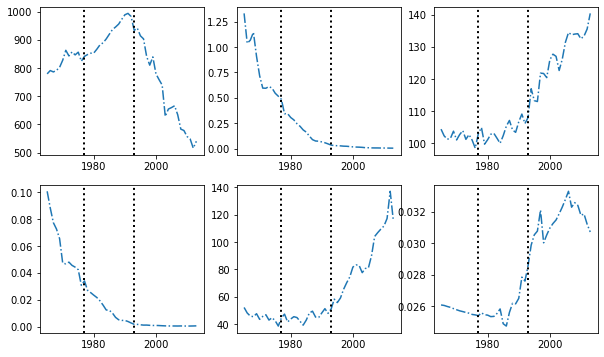

In [17]:
WUI_mean = city_yr.groupby(['Year']).mean()[water_use_density]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 6))
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

# 对比各行业总列，先不细分到二级
wui_cols = [
    'Irrigation water-use intensity (WUI): Total', 'Industrial WUI: Total',
    'Urban domestic WUI', 'Service WUI', 'Rural domestic WUI', 'Livestock WUI'
]

# 绘图
for i, ax in enumerate(axs):
    wui_col = wui_cols[i]
    ax.plot(WUI_mean[wui_col], '-.')

    # 增加辅助线
    ax.axvline(x=1977, ls=":", c='black', lw=2, label='Breakpoint_1: 1978')
    ax.axvline(x=1993, ls=":", c='black', lw=2, label='Breakpoint_2: 1993')

plt.show();

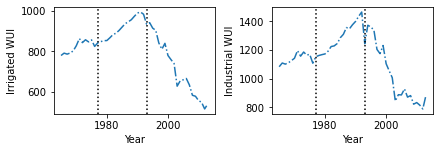

In [18]:
WUI_mean = city_yr.groupby(['Year']).mean()[water_use_density[:2]]

fig, axs = plt.subplots(1, 2, figsize=(6, 2), constrained_layout=True)

for i, ax in enumerate(axs):
    ax.plot(WUI_mean.iloc[:, i], "-.")
    ax.set_xlabel("Year")
    ax.axvline(x=1977, ls=":", lw=1.5, c='black')
    ax.axvline(x=1993, ls=":", lw=1.5, c='black')
    
axs[0].set_ylabel("Irrigated WUI")
axs[1].set_ylabel("Industrial WUI")
# plt.savefig("../figures/sup/rur_and_ind_YRB_WUI.jpg", dpi=300)
plt.show();

## 结果分析

- Service的变化虽然猛烈，但量太少了，不怎么影响。
- 工业的变化也有，但这个时期工业产值的体量太小了
- 其余基本上没什么变化

## 经济社会体量

### 人口总数对比

In [19]:
# 提取所有人口有关的列名
pop_cols = []
for col in city_yr.columns:
    if 'population' in col:
        pop_cols.append(col)

# 各区域的总人口
population_sum = city_yr.groupby(['Region', 'Year']).sum()[pop_cols]
population_sum.head()

Urban population  Rural population  Livestock population
Region Year                                                          
DR     1965          4.115027         29.817675           1493.631791
       1966          4.300493         30.992345           1657.178879
       1967          4.494439         32.119556           1750.603275
       1968          4.697260         33.199307           1849.428670
       1969          4.909369         34.231599           1953.984111

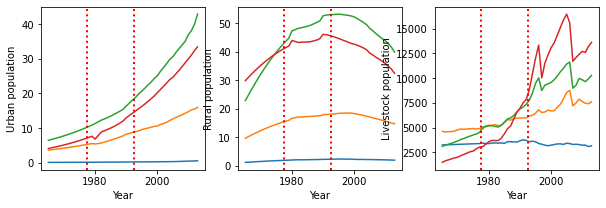

In [20]:
# 对比不同区域的人口数量变化

fig,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
axs = [ax1, ax2, ax3]
for i in range(3):
    ax = axs[i]
    pop_col = pop_cols[i]
    compare_regions_lineplot(population_sum, pop_col, ax)
    ax.axvline(x=1977.5, ls=":", c='red', lw=2, label='Breakpoint_1: 1978')
    ax.axvline(x=1992.5, ls=":", c='red', lw=2, label='Breakpoint_2: 1993')
plt.show();

### 经济体量对比

In [21]:
# 提取所有经济总量有关的列名

gva_cols = []
for col in city_yr.columns:
    if 'GVA' in col and 'Total' in col:
        gva_cols.append(col)
    if 'area' in col and 'Total' in col:
        gva_cols.append(col)

gva_cols  # 只有两个与经济总量相关的，分别是农业和工业

# 各区域的经济指标总量
gva_sum = city_yr.groupby(['Region', 'Year']).sum()[gva_cols]
gva_sum.head(3)

Irrigated area: Total  Industrial gross value added (GVA): Total
Region Year                                                                  
DR     1965            1165.024377                                   3.308297
       1966            1440.525162                                   3.416090
       1967            1599.388147                                   3.385817

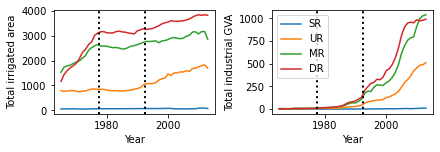

In [22]:
# 作图比较经济体量

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2), constrained_layout=True)
axs = [ax1, ax2]
for i in range(2):
    gva_col = gva_cols[i]
    ax = axs[i]
    compare_regions_lineplot(gva_sum, gva_col, ax)
    ax.axvline(x=1977.5, ls=":", c='black', lw=2)
    ax.axvline(x=1992.5, ls=":", c='black', lw=2)
ax2.set_ylabel("Total industrial GVA")
ax1.set_ylabel("Total irrigated area")
ax2.legend()
# plt.savefig("../figures/sup/sf_total_values.jpg", dpi=300)
plt.show();

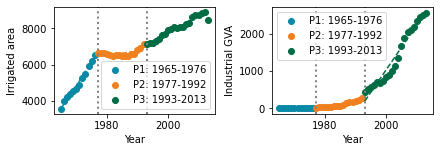

In [23]:
# 整个流域的经济总量
gva_sum = city_yr.groupby(['Year']).sum()[gva_cols]
fig, axs = plt.subplots(1, 2, figsize=(6, 2), constrained_layout=True)

for i, ax in enumerate(axs):
    plot_pittitt_change_points(gva_sum.iloc[:, i], change_points=[1977, 1993], ax=ax, colors=period_colors)
    ax.set_xlabel("Year")
    
axs[0].set_ylabel("Irrigated area")
axs[1].set_ylabel("Industrial GVA")
# plt.savefig("../figures/sup/sf_values_YRB.jpg", dpi=300)
plt.show();

## 地表水总用量

In [24]:
# 提取总用水量有关的列名
wu_cols = ['IRR', 'IND', 'RUR', 'URB']

# 地表水总用量
water_use_sum = city_yr.groupby(['Region', 'Year']).sum()[wu_cols]
water_use_sum.head(3)

IRR       IND       RUR       URB
Region Year                                        
DR     1965  5.284230  1.175082  0.664669  0.253076
       1966  6.614762  1.135651  0.650781  0.255834
       1967  7.345830  1.161734  0.689773  0.270530

各行业的耗水量：


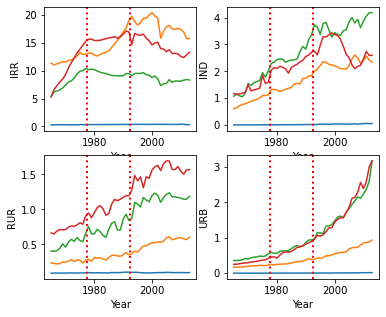

In [25]:
# 对比各领域的地表水总耗水量

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6, 5))
axs = [ax1, ax2, ax3, ax4]

print("各行业的耗水量：")
for i in range(4):
    wu_col = wu_cols[i]
    ax = axs[i]
    compare_regions_lineplot(water_use_sum, wu_col, ax)
    ax.axvline(x=1977.5, ls=":", c='red', lw=2, label='Breakpoint_1: 1978')
    ax.axvline(x=1992.5, ls=":", c='red', lw=2, label='Breakpoint_2: 1993')
plt.show();

# 间接用水部分的变化


## 类型的划分

直接由水提供的生态系统惠益：
- 城市、农村居民用水
- 农业灌溉用水
- 牲畜用水

In [26]:
direct = ['IRR', 'Urban domestic WU', 'Rural domestic WU', 'Rural livestock WU']




间接由水资源提供的生态系统惠益：
- 工业用水
- 服务业用水

In [27]:
undirect = ['IND', 'Urban service WU']

## 非直接用水的比例

In [28]:
# 计算间接比例的变化
def direct_undirect_water_use(row):
    """直接、非直接的用水总量"""
    direct_sum = sum([row[col] for col in direct])
    undirect_sum = sum([row[col] for col in undirect])
    return direct_sum, undirect_sum

# 每行数据是每年，计算每年的非直接用水占比
def undirect_proportion(row):
    """每年的非直接用水比例"""
    direct, undirect = direct_undirect_water_use(row)
    return undirect / (direct + undirect)

## 全流域间接用水占比

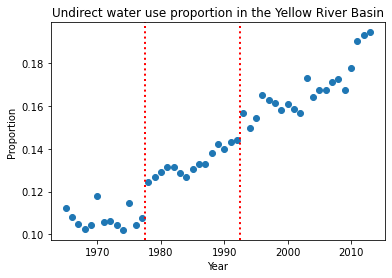

In [29]:
# 整个流域的间接用水占比
undirect_water_proportion_yr = city_yr.groupby('Year').sum().apply(undirect_proportion, axis=1)

# 作图
plt.scatter(x=undirect_water_proportion_yr.index, y=undirect_water_proportion_yr.values)
plt.title('Undirect water use proportion in the Yellow River Basin')
plt.axvline(x=1977.5, ls=":", c='red', lw=2, label='Breakpoint_1: 1978')
plt.axvline(x=1992.5, ls=":", c='red', lw=2, label='Breakpoint_2: 1993')
plt.ylabel('Proportion')
plt.xlabel("Year")
plt.show();

## 分区域间接用水占比

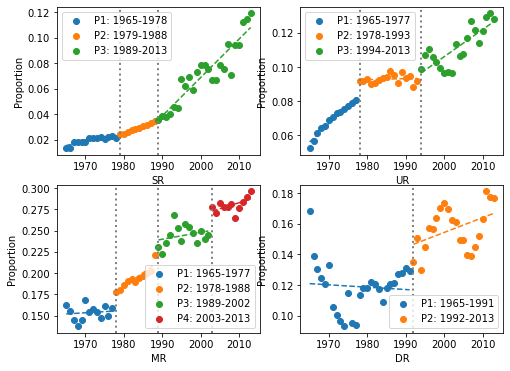

In [30]:
# 分区域间接用水占比
undirect_proportion_regions = city_yr.groupby(['Region', 'Year']).sum()

# 绘图
fig = plt.figure(figsize=(8, 6))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    region = regions[i]
    data = undirect_proportion_regions.loc[region].apply(undirect_proportion, axis=1)
    plot_pittitt_change_points(data, ax)
    ax.set_ylabel('Proportion')
    ax.set_xlabel(region)

plt.show();

1978年以前，下游的非直接比例下降（农业比例上升更快）；1993年后，中游的非直接比例下降（转移）

# 城市与农村用水

## 用水量之比

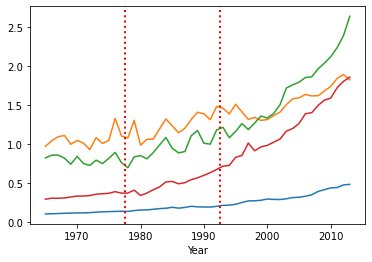

In [31]:
# 用水总量之比

def urban_rural_ratio(row):
    return row['Urban domestic WU'] / row['Rural domestic WU']
    
urban_rural_wu = city_yr.groupby(['Region', 'Year']).sum().apply(urban_rural_ratio, axis=1)

fig, ax = plt.subplots()
compare_regions_lineplot(data=urban_rural_wu, ax=ax)  # 绘图

# 修饰
ax.axvline(x=1977.5, ls=":", c='red', lw=2, label='Breakpoint_1: 1978')
ax.axvline(x=1992.5, ls=":", c='red', lw=2, label='Breakpoint_2: 1993')
plt.show();

## 人均用水量之比

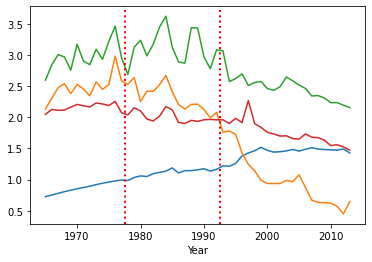

In [32]:
# 人均用水量之比
def urban_rural_wui_ratio(row):
    return row['Urban domestic WUI'] / row['Rural domestic WUI']

urban_rural_wui = city_yr.groupby(['Region', 'Year']).sum().apply(urban_rural_wui_ratio, axis=1)

fig, ax = plt.subplots()
compare_regions_lineplot(data=urban_rural_wui, ax=ax)  # 绘图

# 修饰
ax.axvline(x=1977.5, ls=":", c='red', lw=2, label='Breakpoint_1: 1978')
ax.axvline(x=1992.5, ls=":", c='red', lw=2, label='Breakpoint_2: 1993')
plt.show();

# 探索数据总结：

## 三个阶段的变化

分三个阶段来探讨变化：

**第一阶段：1978年以前**

- 下游农业灌溉面积、农业耗水总量激增
- 下游非直接灌溉用水占比下降（因为农业水增）

**第二阶段：1978--1993**

- 下游农业耗水总量趋于稳定
- 上游农业耗水总量（WU）激增，灌溉面积不变，WUI激增

**第三阶段：1993年以后**

- 上游的农业灌溉单位面积用水量迅速下降（应该是科技原因）
- 工业用水单位用量（WUI）与服务业WUI都趋于稳定。
- 三个区域的城市居民人均用水WUI都快速上升
- 上游农村人均用水量WUI飙升
- 下游牲畜WUI飙升
- 上中下游都到了农村人口下降的拐点
- 工业总产值激增
- 中游的非直接耗水比例快速下降



## 通过哪几个维度分析系统回路

- 首先，“非生态系统服务”的部分在社会-生态系统中的比例不断增长。
- 其次，该过程伴随着专业分工深化和城市不断发展。
- 最后，参与供求关系的地理范围扩大，资源在更大尺度上实现远程耦合。